# EfficientNet-B0

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!unzip -q "/content/drive/MyDrive/AUEB/MURA-v1.1.zip" -d /content/


In [ ]:
import pandas as pd

df = pd.read_csv('/content/MURA-v1.1/train_image_paths.csv')
print(df.head())


  MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image1.png
0  MURA-v1.1/train/XR_SHOULDER/patient00001/study...                 
1  MURA-v1.1/train/XR_SHOULDER/patient00001/study...                 
2  MURA-v1.1/train/XR_SHOULDER/patient00002/study...                 
3  MURA-v1.1/train/XR_SHOULDER/patient00002/study...                 
4  MURA-v1.1/train/XR_SHOULDER/patient00002/study...                 


In [ ]:

df_train = pd.read_csv('/content/MURA-v1.1/train_image_paths.csv')
print(df_train.columns)


Index(['MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image1.png'], dtype='object')


In [ ]:
import pandas as pd
import os

df_train = pd.read_csv('/content/MURA-v1.1/train_image_paths.csv', header=None)
df_train.columns = ['image_path']
df_train['path'] = df_train['image_path'].apply(lambda x: os.path.join('/content', x))
df_train['label'] = df_train['image_path'].apply(lambda x: 1 if 'positive' in x else 0)
df_train['body_part'] = df_train['image_path'].apply(lambda x: x.split('/')[2])  # e.g., 'XR_SHOULDER'


In [ ]:
from sklearn.model_selection import train_test_split

# Create a stratification key combining body part + label
df_train['stratify_group'] = df_train['body_part'] + "_" + df_train['label'].astype(str)

# Stratified 80/20 split
df_train_final, df_val_final = train_test_split(
    df_train,
    test_size=0.2,
    random_state=42,
    stratify=df_train['stratify_group']
)

In [ ]:
# Dropping the helper column
df_train_final = df_train_final.drop(columns=['stratify_group'])
df_val_final = df_val_final.drop(columns=['stratify_group'])

In [ ]:
df_test = pd.read_csv('/content/MURA-v1.1/valid_image_paths.csv', header=None)
df_test.columns = ['image_path']
df_test['path'] = df_test['image_path'].apply(lambda x: os.path.join('/content', x))
df_test['label'] = df_test['image_path'].apply(lambda x: 1 if 'positive' in x else 0)
df_test['body_part'] = df_test['image_path'].apply(lambda x: x.split('/')[2])  # e.g., XR_WRIST


In [ ]:
# Encode body_part as part_idx for conditioning
body_parts = sorted(df_train_final['body_part'].unique())  # Ensure consistent order
part_to_index = {part: idx for idx, part in enumerate(body_parts)}

for df in [df_train_final, df_val_final, df_test]:
    df['part_idx'] = df['body_part'].map(part_to_index)

In [ ]:
# Distribution and Sanity Check

print("Training set:")
print(df_train_final['body_part'].value_counts(normalize=True))

print("\nValidation set:")
print(df_val_final['body_part'].value_counts(normalize=True))


Training set:
body_part
XR_WRIST       0.264960
XR_SHOULDER    0.227637
XR_HAND        0.150581
XR_FINGER      0.138695
XR_ELBOW       0.133974
XR_FOREARM     0.049582
XR_HUMERUS     0.034572
Name: proportion, dtype: float64

Validation set:
body_part
XR_WRIST       0.264874
XR_SHOULDER    0.227656
XR_HAND        0.150638
XR_FINGER      0.138821
XR_ELBOW       0.133931
XR_FOREARM     0.049579
XR_HUMERUS     0.034501
Name: proportion, dtype: float64


In [ ]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torch
import numpy as np


class MuraDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_path = row["image_path"]
        label = row["label"]
        part_idx = row["part_idx"]

        image = Image.open(image_path).convert("L")  # "L" = grayscale


        if self.transform:
            image = self.transform(image)

        return image, label, part_idx



In [ ]:
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize before augmenting
    transforms.RandomHorizontalFlip(p=0.5),   # Minor flip — common in medical images
    transforms.RandomRotation(degrees=10),    # Small angle preserves structure
    transforms.ColorJitter(brightness=0.1, contrast=0.1),  # Slight lighting changes
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # For grayscale

])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # For grayscale

])


In [ ]:
from torch.utils.data import DataLoader

# Train
train_dataset = MuraDataset(df_train_final, transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)

# Validation
val_dataset = MuraDataset(df_val_final, transform=val_transform)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

# Test
test_dataset = MuraDataset(df_test, transform=val_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)


## MultiTask Model

In [ ]:
# 1x224x224 input


import torch
import torch.nn as nn
from torchvision.models import efficientnet_b0

class EfficientNetMultitask(nn.Module):
    def __init__(self, num_body_parts=7, embed_dim=32, pretrained=True, num_views=3):
        super(EfficientNetMultitask, self).__init__()
        self.embed_dim = embed_dim
        self.num_views = num_views

        # Load pretrained EfficientNet-B0
        weights = 'DEFAULT' if pretrained else None
        base = efficientnet_b0(weights=weights)

        # Modify first conv layer to accept grayscale input (1 channel)
        base.features[0][0] = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False)

        self.backbone = base.features
        self.pool = nn.AdaptiveAvgPool2d(1)
        in_features = base.classifier[1].in_features  # 1280 for EfficientNet-B0

        # Part embedding for fracture classification
        self.part_embed = nn.Embedding(num_body_parts, embed_dim)

        # Fracture head
        self.fracture_head = nn.Sequential(
            nn.Linear(in_features + embed_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 2)
        )

        # Body part classification head
        self.bodypart_head = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_body_parts)
        )

    def forward(self, x, part_idx):
        # x: shape (B, 1, 224, 224) → single grayscale image
        features = self.backbone(x)
        features = self.pool(features).squeeze(-1).squeeze(-1)  # shape: (B, 1280)

        part_embedding = self.part_embed(part_idx)              # (B, embed_dim)

        combined = torch.cat((features, part_embedding), dim=1) # (B, 1280 + embed_dim)
        out_fracture = self.fracture_head(combined)
        out_bodypart = self.bodypart_head(features)

        return out_fracture, out_bodypart



## Define loss, optimizer, Scheduler

In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
# Use CrossEntropyLoss for both tasks
fracture_loss_fn = nn.CrossEntropyLoss()
bodypart_loss_fn = nn.CrossEntropyLoss()

# Instantiate model
model = EfficientNetMultitask(num_body_parts=len(part_to_index)).to(device)

# Optimizer and scheduler
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5, verbose=True)


## Training and Validation Loops


In [ ]:
def train_one_epoch(model, loader, optimizer, fracture_loss_fn, bodypart_loss_fn):
    model.train()
    total_loss, correct_frac, correct_part = 0, 0, 0

    for images, labels, part_idxs in loader:
        images = images.to(device)
        labels = labels.to(device)
        part_idxs = part_idxs.to(device)

        optimizer.zero_grad()
        out_fracture, out_bodypart = model(images, part_idxs)

        loss_fracture = fracture_loss_fn(out_fracture, labels)
        loss_bodypart = bodypart_loss_fn(out_bodypart, part_idxs)
        loss = loss_fracture + loss_bodypart

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct_frac += (out_fracture.argmax(1) == labels).sum().item()
        correct_part += (out_bodypart.argmax(1) == part_idxs).sum().item()

    n = len(loader.dataset)
    return total_loss / len(loader), correct_frac / n, correct_part / n



def validate(model, loader, fracture_loss_fn, bodypart_loss_fn):
    model.eval()
    total_loss, correct_frac, correct_part = 0, 0, 0

    with torch.no_grad():
        for images, labels, part_idxs in loader:
            images = images.to(device)
            labels = labels.to(device)
            part_idxs = part_idxs.to(device)

            out_fracture, out_bodypart = model(images, part_idxs)

            loss_fracture = fracture_loss_fn(out_fracture, labels)
            loss_bodypart = bodypart_loss_fn(out_bodypart, part_idxs)
            loss = loss_fracture + loss_bodypart

            total_loss += loss.item()
            correct_frac += (out_fracture.argmax(1) == labels).sum().item()
            correct_part += (out_bodypart.argmax(1) == part_idxs).sum().item()

    n = len(loader.dataset)
    return total_loss / len(loader), correct_frac / n, correct_part / n


## Training

In [ ]:
best_val_loss = float('inf')
early_stop_counter = 0
early_stop_patience = 5
epochs = 20

for epoch in range(epochs):
    train_loss, train_fracture_acc, train_part_acc = train_one_epoch(model, train_loader, optimizer, fracture_loss_fn, bodypart_loss_fn)
    val_loss, val_fracture_acc, val_part_acc = validate(model, val_loader, fracture_loss_fn, bodypart_loss_fn)

    print(f"Epoch {epoch+1}/{epochs} | "
          f"Train Loss: {train_loss:.4f}, Frac Acc: {train_fracture_acc:.4f}, Part Acc: {train_part_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Frac Acc: {val_fracture_acc:.4f}, Part Acc: {val_part_acc:.4f}")

    scheduler.step(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
        torch.save(model.state_dict(), "efficientnet_multitask.pt")
    else:
        early_stop_counter += 1
        print(f"Early stop patience: {early_stop_counter}/5")
        if early_stop_counter >= early_stop_patience:
            print("Early stopping triggered.")
            break


Epoch 1/20 | Train Loss: 0.8870, Frac Acc: 0.7151, Part Acc: 0.8997 | Val Loss: 0.5856, Frac Acc: 0.7766, Part Acc: 0.9709
Epoch 2/20 | Train Loss: 0.5874, Frac Acc: 0.7786, Part Acc: 0.9704 | Val Loss: 0.5424, Frac Acc: 0.8044, Part Acc: 0.9745
Epoch 3/20 | Train Loss: 0.5350, Frac Acc: 0.7997, Part Acc: 0.9772 | Val Loss: 0.5175, Frac Acc: 0.8097, Part Acc: 0.9770
Epoch 4/20 | Train Loss: 0.5023, Frac Acc: 0.8093, Part Acc: 0.9811 | Val Loss: 0.5153, Frac Acc: 0.8135, Part Acc: 0.9761
Epoch 5/20 | Train Loss: 0.4732, Frac Acc: 0.8212, Part Acc: 0.9831 | Val Loss: 0.5016, Frac Acc: 0.8222, Part Acc: 0.9783
Epoch 6/20 | Train Loss: 0.4483, Frac Acc: 0.8296, Part Acc: 0.9847 | Val Loss: 0.5027, Frac Acc: 0.8244, Part Acc: 0.9789
Early stop patience: 1/5
Epoch 7/20 | Train Loss: 0.4290, Frac Acc: 0.8367, Part Acc: 0.9862 | Val Loss: 0.5211, Frac Acc: 0.8217, Part Acc: 0.9792
Early stop patience: 2/5
Epoch 8/20 | Train Loss: 0.4065, Frac Acc: 0.8434, Part Acc: 0.9892 | Val Loss: 0.4951, F

## Evaluation Fracture

In [ ]:
from sklearn.metrics import classification_report, roc_auc_score, cohen_kappa_score

def evaluate_fracture_task(model, test_loader):
    model.eval()
    model.to(device)
    all_labels = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for images, labels, part_idxs in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            part_idxs = part_idxs.to(device)

            out_fracture, _ = model(images, part_idxs)

            probs = torch.softmax(out_fracture, dim=1)[:, 1].cpu().numpy()
            preds = out_fracture.argmax(dim=1).cpu().numpy()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds)
            all_probs.extend(probs)

    print("Fracture Classification Report:")
    print(classification_report(all_labels, all_preds, digits=4))
    print("ROC AUC Score:", roc_auc_score(all_labels, all_probs))
    print("Cohen's Kappa Score:", cohen_kappa_score(all_labels, all_preds))


## Evaluation Body Part

In [ ]:
def evaluate_bodypart_task(model, loader, index_to_part=None):
    model.eval()
    model.to(device)
    all_parts = []
    all_preds = []

    with torch.no_grad():
        for images, _, part_idxs in loader:
            images = images.to(device)
            part_idxs = part_idxs.to(device)

            _, out_bodypart = model(images, part_idxs)
            preds = out_bodypart.argmax(dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_parts.extend(part_idxs.cpu().numpy())

    print("\n--- Body Part Classification Report ---")
    if index_to_part:
        target_names = [index_to_part[i] for i in sorted(set(all_parts))]
    else:
        target_names = None

    print(classification_report(all_parts, all_preds, target_names=target_names, digits=4))


In [ ]:
# In case it's not already defined in current scope
index_to_part = {v: k for k, v in part_to_index.items()}

# Load model
model.load_state_dict(torch.load("efficientnet_multitask.pt"))

# Evaluate fracture classification and body part classification
evaluate_fracture_task(model, test_loader)
evaluate_bodypart_task(model, test_loader, index_to_part=index_to_part)


Fracture Classification Report:
              precision    recall  f1-score   support

           0     0.7665    0.9040    0.8296      1667
           1     0.8700    0.7000    0.7758      1530

    accuracy                         0.8064      3197
   macro avg     0.8183    0.8020    0.8027      3197
weighted avg     0.8161    0.8064    0.8039      3197

ROC AUC Score: 0.8709520840929853
Cohen's Kappa Score: 0.6089089510256505

--- Body Part Classification Report ---
              precision    recall  f1-score   support

    XR_ELBOW     0.9502    0.9849    0.9673       465
   XR_FINGER     0.9867    0.9631    0.9748       461
  XR_FOREARM     0.9664    0.8605    0.9104       301
     XR_HAND     0.9555    0.9804    0.9678       460
  XR_HUMERUS     0.9716    0.9514    0.9614       288
 XR_SHOULDER     0.9808    1.0000    0.9903       563
    XR_WRIST     0.9656    0.9803    0.9729       659

    accuracy                         0.9681      3197
   macro avg     0.9681    0.9601    0

# Generalization Test on EfficientNet

In [ ]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True


In [ ]:
import os
from glob import glob

fractured_dir = "/content/drive/MyDrive/AUEB/Deep Learning/fractured"
not_fractured_dir = "/content/drive/MyDrive/AUEB/Deep Learning/not fractured"



fractured_paths = glob(os.path.join(fractured_dir, '*'))
not_fractured_paths = glob(os.path.join(not_fractured_dir, '*'))




In [ ]:
print(f"Fractured images: {len(fractured_paths)}")
print(f"Not fractured images: {len(not_fractured_paths)}")
print(f"Total: {len(fractured_paths) + len(not_fractured_paths)}")

Fractured images: 337
Not fractured images: 492
Total: 829


In [ ]:
from PIL import Image
from torch.utils.data import Dataset
import torchvision.transforms as transforms

test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

class CustomXrayDataset(Dataset):
    def __init__(self, image_paths, label, transform=None):
        self.image_paths = image_paths
        self.label = label  # 0 = no fracture, 1 = fracture
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("L")
        if self.transform:
            image = self.transform(image)
        return image, self.label, 0  # 0 = dummy body part index


In [ ]:
from torch.utils.data import DataLoader

fractured_ds = CustomXrayDataset(fractured_paths, label=1, transform=test_transform)
notfractured_ds = CustomXrayDataset(not_fractured_paths, label=0, transform=test_transform)

from torch.utils.data import ConcatDataset

combined_ds = ConcatDataset([fractured_ds, notfractured_ds])
combined_loader = DataLoader(combined_ds, batch_size=32, shuffle=False)


In [ ]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels, part_idxs in combined_loader:
        images = images.to(device)
        part_idxs = part_idxs.to(device)
        labels = labels.to(device)

        out_fracture, _ = model(images, part_idxs)
        preds = out_fracture.argmax(1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

print("Custom X-Ray Evaluation:")
print(classification_report(all_labels, all_preds, target_names=["Not Fractured", "Fractured"]))
print("Confusion Matrix:")
print(confusion_matrix(all_labels, all_preds))


Custom X-Ray Evaluation:
               precision    recall  f1-score   support

Not Fractured       0.72      0.98      0.83       492
    Fractured       0.94      0.44      0.60       337

     accuracy                           0.76       829
    macro avg       0.83      0.71      0.72       829
 weighted avg       0.81      0.76      0.74       829

Confusion Matrix:
[[482  10]
 [188 149]]


# DenseNet169

In [ ]:
import torch
import torch.nn as nn
from torchvision.models import densenet169

class DenseNet169Multitask(nn.Module):
    def __init__(self, num_body_parts=7, embed_dim=32, pretrained=True):
        super(DenseNet169Multitask, self).__init__()

        # Load pretrained DenseNet169
        weights = 'IMAGENET1K_V1' if pretrained else None
        base = densenet169(weights=weights)

        # Modify first conv layer to accept grayscale (1 channel)
        original_conv = base.features.conv0
        base.features.conv0 = nn.Conv2d(
            in_channels=1,
            out_channels=original_conv.out_channels,
            kernel_size=original_conv.kernel_size,
            stride=original_conv.stride,
            padding=original_conv.padding,
            bias=False
        )

        self.features = base.features
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.feature_dim = base.classifier.in_features  # 1664 for DenseNet169

        # Embedding for body part index
        self.part_embed = nn.Embedding(num_body_parts, embed_dim)

        # Fracture classification head
        self.fracture_head = nn.Sequential(
            nn.Linear(self.feature_dim + embed_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 2)
        )

        # Body part classification head
        self.bodypart_head = nn.Sequential(
            nn.Linear(self.feature_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_body_parts)
        )

    def forward(self, x, part_idx):
        x = self.features(x)
        x = self.pool(x).view(x.size(0), -1)

        part_feat = self.part_embed(part_idx)
        combined = torch.cat([x, part_feat], dim=1)
        out_fracture = self.fracture_head(combined)
        out_bodypart = self.bodypart_head(x)

        return out_fracture, out_bodypart


In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
# Use CrossEntropyLoss for both tasks
fracture_loss_fn = nn.CrossEntropyLoss()
bodypart_loss_fn = nn.CrossEntropyLoss()

# Instantiate model
model = DenseNet169Multitask(num_body_parts=len(part_to_index)).to(device)

# Optimizer and scheduler
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5, verbose=True)


Downloading: "https://download.pytorch.org/models/densenet169-b2777c0a.pth" to /root/.cache/torch/hub/checkpoints/densenet169-b2777c0a.pth
100%|██████████| 54.7M/54.7M [00:00<00:00, 123MB/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [ ]:
def train_one_epoch(model, loader, optimizer, fracture_loss_fn, bodypart_loss_fn):
    model.train()
    total_loss, correct_frac, correct_part = 0, 0, 0

    for images, labels, part_idxs in loader:
        images = images.to(device)
        labels = labels.to(device)
        part_idxs = part_idxs.to(device)

        optimizer.zero_grad()
        out_fracture, out_bodypart = model(images, part_idxs)

        loss_fracture = fracture_loss_fn(out_fracture, labels)
        loss_bodypart = bodypart_loss_fn(out_bodypart, part_idxs)
        loss = loss_fracture + loss_bodypart

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct_frac += (out_fracture.argmax(1) == labels).sum().item()
        correct_part += (out_bodypart.argmax(1) == part_idxs).sum().item()

    n = len(loader.dataset)
    return total_loss / len(loader), correct_frac / n, correct_part / n



def validate(model, loader, fracture_loss_fn, bodypart_loss_fn):
    model.eval()
    total_loss, correct_frac, correct_part = 0, 0, 0

    with torch.no_grad():
        for images, labels, part_idxs in loader:
            images = images.to(device)
            labels = labels.to(device)
            part_idxs = part_idxs.to(device)

            out_fracture, out_bodypart = model(images, part_idxs)

            loss_fracture = fracture_loss_fn(out_fracture, labels)
            loss_bodypart = bodypart_loss_fn(out_bodypart, part_idxs)
            loss = loss_fracture + loss_bodypart

            total_loss += loss.item()
            correct_frac += (out_fracture.argmax(1) == labels).sum().item()
            correct_part += (out_bodypart.argmax(1) == part_idxs).sum().item()

    n = len(loader.dataset)
    return total_loss / len(loader), correct_frac / n, correct_part / n


In [ ]:
best_val_loss = float('inf')
early_stop_counter = 0
early_stop_patience = 5
epochs = 20

for epoch in range(epochs):
    train_loss, train_fracture_acc, train_part_acc = train_one_epoch(model, train_loader, optimizer, fracture_loss_fn, bodypart_loss_fn)
    val_loss, val_fracture_acc, val_part_acc = validate(model, val_loader, fracture_loss_fn, bodypart_loss_fn)

    print(f"Epoch {epoch+1}/{epochs} | "
          f"Train Loss: {train_loss:.4f}, Frac Acc: {train_fracture_acc:.4f}, Part Acc: {train_part_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Frac Acc: {val_fracture_acc:.4f}, Part Acc: {val_part_acc:.4f}")

    scheduler.step(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
        torch.save(model.state_dict(), "DenseNet169Multitask.pt")
    else:
        early_stop_counter += 1
        print(f"Early stop patience: {early_stop_counter}/5")
        if early_stop_counter >= early_stop_patience:
            print("Early stopping triggered.")
            break


Epoch 1/20 | Train Loss: 0.8180, Frac Acc: 0.7226, Part Acc: 0.9219 | Val Loss: 0.6182, Frac Acc: 0.7683, Part Acc: 0.9643
Epoch 2/20 | Train Loss: 0.5930, Frac Acc: 0.7793, Part Acc: 0.9697 | Val Loss: 0.5558, Frac Acc: 0.7886, Part Acc: 0.9747
Epoch 3/20 | Train Loss: 0.5501, Frac Acc: 0.7936, Part Acc: 0.9764 | Val Loss: 0.5689, Frac Acc: 0.7896, Part Acc: 0.9724
Early stop patience: 1/5
Epoch 4/20 | Train Loss: 0.5165, Frac Acc: 0.8058, Part Acc: 0.9793 | Val Loss: 0.5273, Frac Acc: 0.8051, Part Acc: 0.9758
Epoch 5/20 | Train Loss: 0.4904, Frac Acc: 0.8142, Part Acc: 0.9831 | Val Loss: 0.5254, Frac Acc: 0.8044, Part Acc: 0.9769
Epoch 6/20 | Train Loss: 0.4697, Frac Acc: 0.8236, Part Acc: 0.9834 | Val Loss: 0.5226, Frac Acc: 0.8115, Part Acc: 0.9758
Epoch 7/20 | Train Loss: 0.4520, Frac Acc: 0.8268, Part Acc: 0.9838 | Val Loss: 0.5257, Frac Acc: 0.8082, Part Acc: 0.9765
Early stop patience: 1/5
Epoch 8/20 | Train Loss: 0.4277, Frac Acc: 0.8357, Part Acc: 0.9874 | Val Loss: 0.5350, F

In [ ]:
from sklearn.metrics import classification_report, roc_auc_score, cohen_kappa_score

def evaluate_fracture_task(model, test_loader):
    model.eval()
    all_labels = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for images, labels, part_idxs in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            part_idxs = part_idxs.to(device)

            out_fracture, _ = model(images, part_idxs)

            probs = torch.softmax(out_fracture, dim=1)[:, 1].cpu().numpy()
            preds = out_fracture.argmax(dim=1).cpu().numpy()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds)
            all_probs.extend(probs)

    print("Fracture Classification Report:")
    print(classification_report(all_labels, all_preds, digits=4))
    print("ROC AUC Score:", roc_auc_score(all_labels, all_probs))
    print("Cohen's Kappa Score:", cohen_kappa_score(all_labels, all_preds))


In [ ]:
def evaluate_bodypart_task(model, loader, index_to_part=None):
    model.eval()
    all_parts = []
    all_preds = []

    with torch.no_grad():
        for images, _, part_idxs in loader:
            images = images.to(device)
            part_idxs = part_idxs.to(device)

            _, out_bodypart = model(images, part_idxs)
            preds = out_bodypart.argmax(dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_parts.extend(part_idxs.cpu().numpy())

    print("\n--- Body Part Classification Report ---")
    if index_to_part:
        target_names = [index_to_part[i] for i in sorted(set(all_parts))]
    else:
        target_names = None

    print(classification_report(all_parts, all_preds, target_names=target_names, digits=4))


In [ ]:
# In case it's not already defined in current scope
index_to_part = {v: k for k, v in part_to_index.items()}

# Load model
model.load_state_dict(torch.load("DenseNet169Multitask.pt"))

# Evaluate fracture classification and body part classification
evaluate_fracture_task(model, test_loader)
evaluate_bodypart_task(model, test_loader, index_to_part=index_to_part)


Fracture Classification Report:
              precision    recall  f1-score   support

           0     0.7515    0.8980    0.8183      1667
           1     0.8589    0.6765    0.7569      1530

    accuracy                         0.7920      3197
   macro avg     0.8052    0.7872    0.7876      3197
weighted avg     0.8029    0.7920    0.7889      3197

ROC AUC Score: 0.8540966316540614
Cohen's Kappa Score: 0.579549668297902

--- Body Part Classification Report ---
              precision    recall  f1-score   support

    XR_ELBOW     0.9197    0.9849    0.9512       465
   XR_FINGER     0.9781    0.9675    0.9727       461
  XR_FOREARM     0.9446    0.8505    0.8951       301
     XR_HAND     0.9634    0.9739    0.9686       460
  XR_HUMERUS     0.9849    0.9062    0.9439       288
 XR_SHOULDER     0.9824    0.9911    0.9867       563
    XR_WRIST     0.9599    0.9818    0.9707       659

    accuracy                         0.9615      3197
   macro avg     0.9619    0.9509    0.

# Visuals

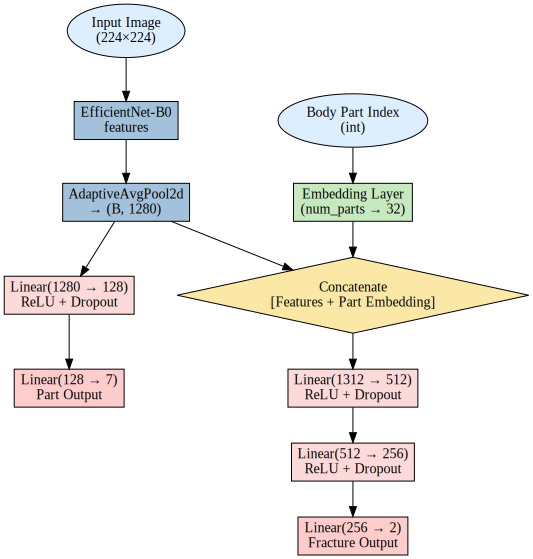

In [ ]:
from graphviz import Digraph

def efficientnet_multitask_architecture():
    dot = Digraph(comment='EfficientNet Multi-task Architecture')
    dot.attr(rankdir='TB', splines='spline', nodesep='0.6', ranksep='0.5')

    # Inputs
    dot.node('input', 'Input Image\n(224×224)', shape='ellipse', style='filled', fillcolor='#DDEEFF')
    dot.node('part_idx', 'Body Part Index\n(int)', shape='ellipse', style='filled', fillcolor='#DDEEFF')

    # Image path
    dot.node('efficientnet', 'EfficientNet-B0\nfeatures', shape='box', style='filled', fillcolor='#A3C1DA')
    dot.node('gap', 'AdaptiveAvgPool2d\n→ (B, 1280)', shape='box', style='filled', fillcolor='#A3C1DA')

    # Embedding path
    dot.node('embed', 'Embedding Layer\n(num_parts → 32)', shape='box', style='filled', fillcolor='#C7E9C0')

    # Body part prediction head
    dot.node('body_fc1', 'Linear(1280 → 128)\nReLU + Dropout', shape='box', style='filled', fillcolor='#FDD9D9')
    dot.node('body_fc2', 'Linear(128 → 7)\nPart Output', shape='box', style='filled', fillcolor='#FFCCCC')

    # Merge
    dot.node('concat', 'Concatenate\n[Features + Part Embedding]', shape='diamond', style='filled', fillcolor='#FBE8A6')

    # Fracture prediction head
    dot.node('fracture_fc1', 'Linear(1312 → 512)\nReLU + Dropout', shape='box', style='filled', fillcolor='#FDD9D9')
    dot.node('fracture_fc2', 'Linear(512 → 256)\nReLU + Dropout', shape='box', style='filled', fillcolor='#FDD9D9')
    dot.node('fracture_fc3', 'Linear(256 → 2)\nFracture Output', shape='box', style='filled', fillcolor='#FFCCCC')

    # Connections
    dot.edge('input', 'efficientnet')
    dot.edge('efficientnet', 'gap')
    dot.edge('gap', 'body_fc1')
    dot.edge('body_fc1', 'body_fc2')
    dot.edge('gap', 'concat')
    dot.edge('part_idx', 'embed')
    dot.edge('embed', 'concat')
    dot.edge('concat', 'fracture_fc1')
    dot.edge('fracture_fc1', 'fracture_fc2')
    dot.edge('fracture_fc2', 'fracture_fc3')

    return dot

# Generate and display
efficientnet_diagram = efficientnet_multitask_architecture()
efficientnet_diagram.render(filename='efficientnet_multitask_architecture', format='png', cleanup=False)
display(efficientnet_diagram)


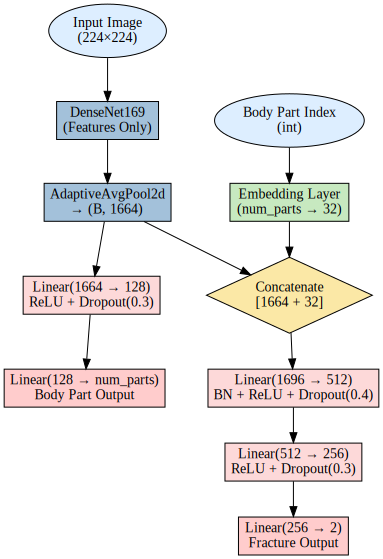

In [ ]:
from graphviz import Digraph
from IPython.display import display

def densenet169_multitask_architecture():
    dot = Digraph(comment='DenseNet169 Multi-task Architecture')
    dot.attr(rankdir='TB', splines='spline', nodesep='0.6', ranksep='0.5')

    # Input & Part index
    dot.node('input', 'Input Image\n(224×224)', shape='ellipse', style='filled', fillcolor='#DDEEFF')
    dot.node('part_idx', 'Body Part Index\n(int)', shape='ellipse', style='filled', fillcolor='#DDEEFF')

    # DenseNet path
    dot.node('densenet', 'DenseNet169\n(Features Only)', shape='box', style='filled', fillcolor='#A3C1DA')
    dot.node('pool', 'AdaptiveAvgPool2d\n→ (B, 1664)', shape='box', style='filled', fillcolor='#A3C1DA')

    # Embedding path
    dot.node('embed', 'Embedding Layer\n(num_parts → 32)', shape='box', style='filled', fillcolor='#C7E9C0')

    # Part prediction
    dot.node('body_fc1', 'Linear(1664 → 128)\nReLU + Dropout(0.3)', shape='box', style='filled', fillcolor='#FDD9D9')
    dot.node('body_fc2', 'Linear(128 → num_parts)\nBody Part Output', shape='box', style='filled', fillcolor='#FFCCCC')

    # Merge
    dot.node('concat', 'Concatenate\n[1664 + 32]', shape='diamond', style='filled', fillcolor='#FBE8A6')

    # Fracture classification head
    dot.node('fracture_fc1', 'Linear(1696 → 512)\nBN + ReLU + Dropout(0.4)', shape='box', style='filled', fillcolor='#FDD9D9')
    dot.node('fracture_fc2', 'Linear(512 → 256)\nReLU + Dropout(0.3)', shape='box', style='filled', fillcolor='#FDD9D9')
    dot.node('fracture_fc3', 'Linear(256 → 2)\nFracture Output', shape='box', style='filled', fillcolor='#FFCCCC')

    # Connections
    dot.edge('input', 'densenet')
    dot.edge('densenet', 'pool')
    dot.edge('pool', 'body_fc1')
    dot.edge('body_fc1', 'body_fc2')
    dot.edge('pool', 'concat')
    dot.edge('part_idx', 'embed')
    dot.edge('embed', 'concat')
    dot.edge('concat', 'fracture_fc1')
    dot.edge('fracture_fc1', 'fracture_fc2')
    dot.edge('fracture_fc2', 'fracture_fc3')

    return dot

# Generate and display
densenet_diagram = densenet169_multitask_architecture()
densenet_diagram.render(filename='densenet169_multitask_architecture', format='png', cleanup=False)
display(densenet_diagram)
